In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns
import os
from itertools import permutations
from sklearn.decomposition import PCA
import umap.umap_ as umap
np.random.seed(42)

%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

In [ ]:
# Set data input folder
# Download files described in README.md to this folder
input_folder = "inputs"

# set output folder
output_folder = "outputs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder, exist_ok=True)

In [ ]:
# Import the A549 guide-level profiles
df_guide = pd.read_csv("../Profile_Aggregation/outputs/20200805_A549_WG_Screen_guide_normalized_feature_select_merged_median_ALLBATCHES___CP186___ALLWELLS.csv.gz")
# Import the A549 gene-level profiles
df_gene = pd.read_csv("../Profile_Aggregation/outputs/20200805_A549_WG_Screen_guide_normalized_feature_select_merged_median_ALLBATCHES___CP186___ALLWELLS_gene_aggregated.csv.gz")

# Figure 2A and 2B

In [2]:
# Extract the features from the guide level profiles
features = list(df_guide.columns)[2:]
mito_list = [feature for feature in df_guide.columns if 'mito'  in feature.lower()]
cona_list = [feature for feature in df_guide.columns if 'cona'  in feature.lower()]
dapi_list = [feature for feature in df_guide.columns if 'dapi'  in feature.lower()]
wga_list = [feature for feature in df_guide.columns if 'wga'  in feature.lower()]
phalloidin_list = [feature for feature in df_guide.columns if 'phalloidin'  in feature.lower()]
print('Number of features per compartment: ','\n',
      'Mito features: ',len(mito_list),'\n',
      'ConA features: ',len(cona_list),'\n',
      'DAPI features: ',len(dapi_list),'\n',
      'WGA features: ',len(wga_list),'\n',
      'Phalloidin features: ',len(phalloidin_list))

Number of features per compartment:  
 Mito features:  346 
 ConA features:  221 
 DAPI features:  321 
 WGA features:  285 
 Phalloidin features:  254


In [ ]:
# Load p_values from the hit calling process
df_p_values = pd.read_csv('../Hit_Calling/outputs/A549_significant_features_mann_whitney_p_values.csv')

# Load expression data 
express = pd.read_csv("../common_files/A549_expression_categorized.csv")
zero_tpm_list = express['zero_tpm_genes']
expressed_gene_list = express['expressed_genes']


,Cells_AreaShape_CentralMoment_0_1,Cells_AreaShape_CentralMoment_0_3,Cells_AreaShape_CentralMoment_1_0,Cells_AreaShape_CentralMoment_1_2,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_HuMoment_1,Cells_AreaShape_HuMoment_6,Cells_AreaShape_NormalizedMoment_0_2,...,Nuclei_Texture_SumVariance_ConA_5_01_256,Nuclei_Texture_SumVariance_DAPI_Painting_10_01_256,Nuclei_Texture_SumVariance_DAPI_Painting_10_03_256,Nuclei_Texture_SumVariance_Mito_5_01_256,Nuclei_Texture_SumVariance_Phalloidin_10_01_256,Nuclei_Texture_SumVariance_Phalloidin_10_03_256,Nuclei_Texture_SumVariance_Phalloidin_5_01_256,Nuclei_Texture_SumVariance_WGA_10_01_256,Nuclei_Texture_SumVariance_WGA_10_03_256,Nuclei_Texture_SumVariance_WGA_5_03_256
,,,,,,,,,,,,,,,,,,,,,
A1BG,0.040465,0.268716,0.089515,0.200593,0.295876,0.097683,0.142518,0.877872,0.074688,0.254214,...,0.161008,0.839141,0.373599,0.330441,0.226866,0.064084,0.297633,0.087393,0.103179,0.138432
A1CF,0.083927,0.085997,0.094643,1.000000,0.083938,0.927443,0.722767,0.084620,0.995196,0.087393,...,0.928541,0.049146,0.780339,0.015898,0.001052,0.005448,0.001110,0.023386,0.535020,0.174957
A2M,0.109747,0.044130,0.688935,0.882157,0.522607,0.013581,0.001268,0.121153,0.000278,0.986377,...,0.482139,0.351600,0.093902,0.295876,0.503058,0.934984,0.552645,0.780339,0.440037,0.125774
A2ML1,0.212598,0.100794,0.090957,0.123282,0.983351,0.025305,0.944039,0.166663,0.063077,0.853997,...,0.762702,0.612483,0.931967,0.377688,0.398545,0.357517,0.954614,0.219657,0.007602,0.322955
A3GALT2,0.181053,0.971246,0.717084,0.995619,0.283775,0.093160,0.771617,0.100794,0.070533,0.283775,...,0.183268,0.045752,0.152049,0.001268,0.880865,0.476822,0.260591,0.225411,0.192463,0.562843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11B,0.066007,0.084620,0.146688,0.092442,0.547581,0.889853,0.156438,0.547581,0.148391,0.009194,...,0.683155,0.142518,0.719927,0.848048,0.601872,0.083260,0.085306,0.910879,0.913888,0.479176
ZYX,0.028847,0.440037,0.928949,0.090097,0.995459,0.292384,0.258986,0.998486,0.000287,0.095400,...,0.899512,0.090963,0.005876,0.525078,0.931967,0.078639,0.171366,0.036731,0.486275,0.705781
ZZEF1,0.039547,0.096156,0.164341,0.006526,0.874881,0.215410,0.652985,0.232755,0.040822,0.089521,...,0.201969,0.895853,0.910879,0.345746,0.209841,0.467471,0.152049,0.995459,0.295876,0.774521


In [6]:
# Quantification of number of significant features per compartment at a certain p-value
p_value = 0.001
gene_list = list(df_p_values.index)

df_sig_feature = pd.DataFrame(index=gene_list)
for gene in gene_list:
    # Count mito features 
    mito_c = 0 
    for feat in mito_list:
        #print(len(mito_list))
        if df_p_values.loc[gene,feat] < p_value:
            mito_c += 1 
    # Count cona features 
    cona_c = 0 
    for feat in cona_list:
        #print(df_p_values_mito.loc[f'{gene}'][feat])
        if df_p_values.loc[gene,feat] < p_value:
            cona_c += 1 
    # Count wga features 
    wga_c = 0 
    for feat in wga_list:
        #print(df_p_values_mito.loc[f'{gene}'][feat])
        if df_p_values.loc[gene,feat] < p_value:
            wga_c += 1 
    # Count dapi features 
    dapi_c = 0 
    for feat in dapi_list:
        #print(df_p_values_mito.loc[f'{gene}'][feat])
        if df_p_values.loc[gene,feat] < p_value:
            dapi_c += 1 
    # Count wga features 
    phal_c = 0 
    for feat in phalloidin_list:
        #print(df_p_values_mito.loc[f'{gene}'][feat])
        if df_p_values.loc[gene,feat] < p_value:
            phal_c += 1 
    # Count all features
    sum_c = 0
    for feat in features:
        #print(df_p_values_mito.loc[f'{gene}'][feat])
        if df_p_values.loc[gene,feat] < p_value:
            sum_c += 1 
            
    df_sig_feature.loc[gene,'Mito'] = mito_c
    df_sig_feature.loc[gene,'ConA'] = cona_c
    df_sig_feature.loc[gene,'WGA'] = wga_c
    df_sig_feature.loc[gene,'DAPI'] = dapi_c
    df_sig_feature.loc[gene,'Phalloidin'] = phal_c
    df_sig_feature.loc[gene,'Sum'] = sum_c
    
df_sig_feature = df_sig_feature.drop(index = 'sig_gene_count')
df_sig_feature.head()

,Mito,ConA,WGA,DAPI,Phalloidin,Sum
A1BG,12.0,15.0,18.0,25.0,17.0,88.0
A1CF,12.0,9.0,16.0,18.0,27.0,89.0
A2M,21.0,13.0,11.0,49.0,20.0,124.0
A2ML1,15.0,13.0,12.0,23.0,14.0,81.0
A3GALT2,32.0,13.0,17.0,37.0,17.0,115.0
...,...,...,...,...,...,...
ZYG11A,19.0,9.0,21.0,9.0,16.0,85.0
ZYG11B,13.0,9.0,13.0,11.0,20.0,74.0
ZYX,29.0,23.0,31.0,30.0,46.0,159.0
ZZEF1,15.0,11.0,14.0,22.0,23.0,90.0


In [7]:
# Perturbations divided into 2 groups of controls with 0 TPM and others
df_sig_feature_zero_tpm = df_sig_feature.loc[zero_tpm_list]
df_sig_feature_expressed = df_sig_feature.loc[expressed_gene_list]
df_sig_feature_zero_tpm.head()

,Mito,ConA,WGA,DAPI,Phalloidin,Sum
A2M,21.0,13.0,11.0,49.0,20.0,124.0
A3GALT2,32.0,13.0,17.0,37.0,17.0,115.0
AADACL2,19.0,12.0,11.0,15.0,13.0,71.0
AADACL3,13.0,9.0,13.0,14.0,15.0,67.0
AADACL4,11.0,12.0,16.0,17.0,16.0,78.0
...,...,...,...,...,...,...
ZPBP,18.0,10.0,18.0,8.0,14.0,73.0
ZPLD1,11.0,10.0,10.0,9.0,13.0,63.0
ZSCAN1,16.0,14.0,22.0,33.0,15.0,103.0
ZSCAN4,13.0,10.0,13.0,22.0,17.0,82.0


In [8]:
# Function for false discovery rate (FDR) calculation

def FDR_5(control_sig_feature):
    total = len(control_sig_feature)
    FDR_5 = int(total/20)
    mito_5, cona_5, wga_5, dapi_5, phal_5, sum_5 = 0,0,0,0,0,0
    channels = ['Mito','ConA','WGA','DAPI','Phalloidin']
    c = 200
    feat_5 = 0
    while feat_5 <= FDR_5:
        feat_5 = len(control_sig_feature.query('Mito > @c'))
        mito_5 = c + 1
        c-=1    
    
    c = 200
    feat_5 = 0
    while feat_5 <= FDR_5:
        feat_5 = len(control_sig_feature.query('ConA > @c'))
        cona_5 = c + 1
        c-=1     
        
    c = 200
    feat_5 = 0
    while feat_5 <= FDR_5:
        feat_5 = len(control_sig_feature.query('WGA > @c'))
        wga_5 = c + 1
        c-=1    
    
    c = 200
    feat_5 = 0
    while feat_5 <= FDR_5:
        feat_5 = len(control_sig_feature.query('DAPI > @c'))
        dapi_5 = c + 1
        c-=1    
    
    c = 200
    feat_5 = 0
    while feat_5 <= FDR_5:
        feat_5 = len(control_sig_feature.query('Phalloidin > @c'))
        phal_5 = c + 1
        c-=1    
        
    c = 200
    feat_5 = 0
    while feat_5 <= FDR_5:
        feat_5 = len(control_sig_feature.query('Sum > @c'))
        sum_5 = c + 1
        c-=1    
    
    return mito_5, cona_5, wga_5, dapi_5, phal_5, sum_5


In [9]:
# Compute and print the threshold for FDR calculations at 5% from the 0 TPM gene perturbations
mito_5, cona_5, wga_5, dapi_5, phal_5,sum_5 = FDR_5(df_sig_feature_zero_tpm)
print('Mito genes', mito_5, '\n', 
      'ConA genes', cona_5, '\n', 
      'WGA genes', wga_5, '\n', 
      'DAPI genes', dapi_5, '\n', 
      'Phalloidin genes', phal_5, '\n',
      'Whole Profile genes', sum_5)

 Mito genes 36 
 ConA genes 23 
 WGA genes 36 
 DAPI genes 52 
 Phalloidin genes 31 
 Sum genes 166


In [10]:
# Save the number of significant features per channel for whole cell hits and compartment hits
A549_whole_cell_hits = df_sig_feature_expressed.query('Sum > @sum_5')
A549_comp_spec_hits = df_sig_feature_expressed.query('Sum <= @sum_5').query('Phalloidin > @phal_5 | DAPI > @dapi_5 | WGA > @wga_5 | ConA > @cona_5 | Mito > @mito_5')
A549_whole_cell_hits.to_csv(os.path.join(output_folder,'A549_plate_level_median_per_feat_sig_genes_5_FDR_whole_cell_hits.csv'),index=True)
A549_comp_spec_hits.to_csv(os.path.join(output_folder,'A549_plate_level_median_per_feat_sig_genes_5_FDR_compartment_specific_hits.csv'),index=True)
A549_whole_cell_hits.head()

,Mito,ConA,WGA,DAPI,Phalloidin,Sum
AAAS,28.0,15.0,43.0,53.0,24.0,171.0
AAMP,18.0,13.0,31.0,35.0,84.0,185.0
ABCA1,37.0,19.0,48.0,27.0,33.0,174.0
ABCA10,27.0,21.0,63.0,67.0,26.0,199.0
ABCB7,32.0,20.0,26.0,108.0,20.0,222.0
...,...,...,...,...,...,...
ZNF839,20.0,17.0,40.0,68.0,27.0,180.0
ZNHIT3,46.0,26.0,24.0,68.0,20.0,189.0
ZSCAN2,24.0,25.0,23.0,100.0,12.0,190.0
ZSCAN21,23.0,15.0,35.0,73.0,30.0,186.0


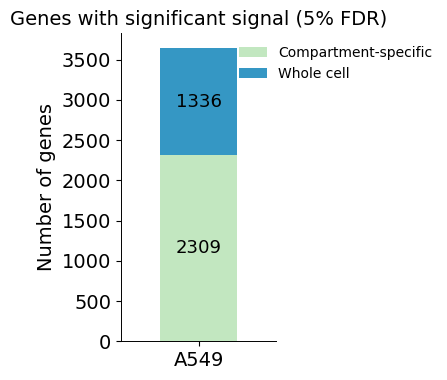

In [11]:
# Plot hits summary for Fig 2A
A549_whole_cell = len(df_sig_feature_expressed.query('Sum > @sum_5'))
A549_comp_spec = len(df_sig_feature_expressed.query('Sum <= @sum_5').query('Phalloidin > @phal_5 | DAPI > @dapi_5 | WGA > @wga_5 | ConA > @cona_5 | Mito > @mito_5'))

mpl.rc('axes', linewidth=0.7)
mpl.rc('xtick', labelsize=14)
mpl.rc('xtick', labelsize=14)

fig, ax = plt.subplots( figsize=(2,4))
colors = sns.color_palette('GnBu')[:8]
hits_plot = pd.DataFrame({'Compartment-specific': [A549_comp_spec],
                         'Whole cell': [A549_whole_cell] },
                        index=['A549'])

hits_plot.plot(kind='bar', 
               stacked=True,
               color=[colors[1], colors[4]],
               legend = 'reverse',
               rot = 0,
               fontsize= 14,
               width = 0.5,
               ax=ax)

ax.set_title('Genes with significant signal (5% FDR)',size=14)
ax.set_ylabel('Number of genes',size=14)

ax.bar_label(ax.containers[0],label_type='center',size=13)
ax.bar_label(ax.containers[1],label_type='center',size=13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc="upper left", bbox_to_anchor=(0.68,1),frameon=False, ncol=1)
fig.savefig(os.path.join(output_folder,'Fig2A_A549_whole_cell_compartment_specific_hits.png'),dpi = 300,bbox_inches='tight')

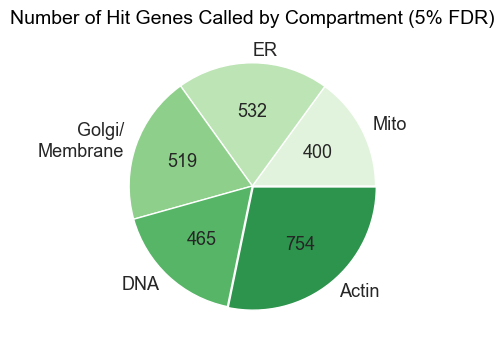

In [12]:
# Plot hits summary for Fig 2B

def absolute_value2(val):
    a  = data[np.abs(data - val/100.*sum(data)).argmin() ]
    return a

labels = ['Mito','ER','Golgi/\nMembrane','DNA','Actin']
data = [len(df_sig_feature_expressed.query('Mito > @mito_5 & Sum <= @sum_5')),
        len(df_sig_feature_expressed.query('ConA > @cona_5 & Sum <= @sum_5')),
        len(df_sig_feature_expressed.query('WGA > @wga_5 & Sum <= @sum_5')),
        len(df_sig_feature_expressed.query('DAPI > @dapi_5 & Sum <= @sum_5')),
        len(df_sig_feature_expressed.query('Phalloidin > @phal_5 & Sum <= @sum_5'))]

colors = sns.color_palette('Greens')[:5]#RdBu
               
fig, ax = plt.subplots(figsize=(7,4))

sns.set_theme(style='white',palette='RdBu')
plt.pie(data,
        labels=labels,
        autopct=absolute_value2,
        colors=colors,
        textprops={'fontsize': 13},
        explode=(0.0, 0.0, 0.0, 0.0, 0.01))
ax.set_title('Number of Hit Genes Called by Compartment (5% FDR)',size=14)
fig.savefig(os.path.join(output_folder,'Fig2B_A549_compartment_specific_hits_distribution.png'),dpi = 300,bbox_inches='tight')

# Figure 2C

In [ ]:
hit_list = list(A549_comp_spec_hits.index) + list(A549_whole_cell_hits.index)
df_hits = df_gene.loc[hit_list]
df_hits.head()

In [ ]:
# Calculate correlation between all gene pairs and create a dictionory of gene pairs/correlation
df_hits_corr = df_hits.T.corr()
genes = list(df_hits_corr.index)
corr_dic = {}
for gene1 in genes:
    for gene2 in genes:
        if len(frozenset([gene1,gene2])) == 1 :
            continue
        else:    
            corr_dic[frozenset([gene1,gene2])]=(df_hits_corr.loc[gene1,gene2])
        
print(f'Gene pair correlation dictionary contains {len(corr_dic)} entries')

In [ ]:
# Input the protein clusters from the CORUM3.0 database and subset the human clusters
ppi_data = pd.read_csv(f'../{input_folder}/CORUM_allComplexes.txt',sep = '\t')
ppi_data_h = ppi_data[ppi_data['Organism'] == "Human"]
ppi_data_h.head()

In [ ]:
# Create a list of protein clusters with all complexes that had at least 66% of genes represented within the A549 WGS hits
cluster_count = 0
hit_cluster_list_list = []
hit_set = set()
for i in range(len(ppi_data_h)):
    cluster = ppi_data_h.iloc[i]['subunits(Gene name)'].split(';')
    count = 0
    hit_cluster_list = []
    for g in cluster:
        if g in genes:
            count += 1
            hit_set.add(g)
            hit_cluster_list.append(g)
    if (count/len(cluster)) >= 0.66:
        cluster_count += 1
    if hit_cluster_list and (count/len(cluster)) >= 0.66:
        hit_cluster_list_list.append(hit_cluster_list)
print(f'There are {len(hit_set)} ')
print(f'There are {cluster_count} ')
print(f'There are {len(hit_cluster_list_list)} ')

In [ ]:
# Assign correlations to hit gene pairs
hit_pair_set = set()
for l in hit_cluster_list_list:
    for c in list(permutations(l,2)):
        hit_pair_set.add(frozenset(c))

hit_corr_dic = {}
for s in hit_pair_set:
    hit_corr_dic[s] = corr_dic[s]

print(f'There are {len(hit_pair_set)} hit pairs.')
print(f'There are {len(hit_corr_dic)} hit pairs with correlation.')

In [ ]:
# Plot CORUM gene pair correlation distribution for Fig 2C
sns.set_theme(style="white",rc = {'axes.linewidth': 0.7,'xtick.labelsize':17,'ytick.labelsize':17})

fig, ax = plt.subplots(figsize=(7,4))
a = list(corr_dic.values())
b = list(hit_corr_dic.values())

sns.histplot(a ,color='b' ,stat= 'percent' ,bins= 100, kde=True, line_kws={'lw':1.4} , alpha=0.5,ax = ax);
sns.histplot(b ,color='r' ,stat= 'percent' ,bins= 100, kde=True, line_kws={'lw':1.4} ,alpha=0.5,ax = ax);

ax.set_ylabel('Gene pair frequency',size=17)
ax.set_xlabel('Correlation of profiles',size=17)
font = font_manager.FontProperties(size=14)
ax.legend(['Hit gene pairs','Hit gene pairs in CORUM complex'],loc='upper left',prop=font )
sns.despine(top = True)

fig.savefig(os.path.join(output_folder,'Fig2C_A549_CORUM_gene_pair_correlation_distribution.png'), dpi=300,facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()

# Figure 2D

In [ ]:
# Import predicted protein links from v11.5 of STRING (9606.protein.links.v11.5.txt.gz) as well as the metadata (9606.protein.info.v11.5.txt.gz)
# Then parse the data into a dataframe
ppi_data = pd.read_csv(os.path.join(input_folder,'9606.protein.links.v11.5.txt.gz'),sep = ' ')
p_names = pd.read_csv(os.path.join(input_folder,'9606.protein.info.v11.5.txt.gz'),sep = '\t')

p_names_dic = {p_names.iloc[i]['#string_protein_id']:p_names.iloc[i]['preferred_name'] for i in range(len(p_names))}

p1 = list(ppi_data.protein1)
p2 = list(ppi_data.protein2)
score = list(ppi_data.combined_score)

p1_named = [p_names_dic.get(item)  for item in p1]
p2_named = [p_names_dic.get(item)  for item in p2]

ppi_data_name = pd.DataFrame(list(zip(p1_named, p2_named, score)),
               columns =['protein1', 'protein2','combined_score'])
ppi_data_name.head()

In [ ]:
# Subset the STRING predicted protein links to A549 hits
ppi_data_name_hits = ppi_data_name[ppi_data_name['protein1'].isin(genes) & ppi_data_name['protein2'].isin(genes)]
print(f'Full PPI database is {ppi_data_name.shape()}')
print(f'PPI database subsetted to A549 hits is {ppi_data_name_hits.shape()}')

In [ ]:
# Catalogue all correlations
corr_dic = {}
for gene1 in genes:
    for gene2 in genes:
        if len(frozenset([gene1,gene2])) == 1 :
            continue
        else:    
            corr_dic[frozenset([gene1,gene2])]=(df_hits_corr.loc[gene1,gene2])
        
print('Overall number of paired correlation ' , len(corr_dic))

In [ ]:
# Determine min, max, intervals for profile correlations
corr_min = min(corr_dic.values())
corr_max = max(corr_dic.values())   
interval = (corr_max-corr_min)/6
print(f'Minimum correlation is {corr_min}')
print(f'Maximum correlation is {corr_max}')
print(f'Interval for plotting with 6 bins is {interval}')

In [ ]:
# Bin the correlations into 6 categories 
results = ppi_data_name_hits.copy(deep=True).reset_index(drop=True)
results["correlation"] = ''
results["correlation_bin"] = ''

bins = [-0.81,-0.54,-0.27,0,0.27,0.54,0.81]
for i in range(len(results)):
    gene1 = results.iloc[i]['protein1']
    gene2 = results.iloc[i]['protein2']
    corr_value = corr_dic[frozenset([gene1,gene2])]
    results.at[i , 'correlation'] = corr_value
    if corr_value > bins[5]:
        results.at[i , 'correlation_bin'] = f'{bins[5]} to {bins[6]}'
    elif corr_value > bins[4] and corr_value <= bins[5]:
        results.at[i , 'correlation_bin'] = f'{bins[4]} to {bins[5]}'
    elif corr_value > bins[3] and corr_value <= bins[4]:
        results.at[i , 'correlation_bin'] = f'{bins[3]} to {bins[4]}'
    elif corr_value > bins[2] and corr_value <= bins[3]:
        results.at[i , 'correlation_bin'] = f'{bins[2]} to {bins[3]}'
    elif corr_value > bins[1] and corr_value <= bins[2]:
        results.at[i , 'correlation_bin'] = f'{bins[1]} to {bins[2]}'
    elif corr_value <= bins[1]:
        results.at[i , 'correlation_bin'] = f'{bins[0]} to {bins[1]}'
results.head()

In [ ]:
# Plot STRING score x gene pair correlation for Fig 2D
sns.set_theme(style="white",rc = {'axes.linewidth': 0.7})

fig, ax = plt.subplots(figsize=(7,4))
order = [f'{bins[0]} to {bins[1]}',f'{bins[1]} to {bins[2]}',f'{bins[2]} to {bins[3]}',f'{bins[3]} to {bins[4]}',f'{bins[4]} to {bins[5]}',f'{bins[5]} to {bins[6]}']

flierprops = dict(markerfacecolor='white', markersize=0.1, linestyle='none')
sns.boxenplot(data=results,
            x = 'correlation_bin',
            y = 'combined_score', 
            #k_depth = 'trustworthy',
            #whis = [10, 90], 
            #flierprops = flierprops,
            order=order, 
            width = 0.6,
            palette = 'RdBu_r',
            ax=ax)

ax.set_xlabel('Correlation of profiles',size=16)
ax.set_ylabel('STRING score',size=16)
ax.tick_params(axis='both', which='major', labelsize=14)
labels = [item for item in ax.get_yticks()]
ax.set_yticklabels([str(round(float(label))) for label in labels], size=16)
ax.set_xticklabels(order, size=16,rotation=30)
sns.despine(top = True,left=False,bottom=False)

fig.savefig(os.path.join(output_folder,'Fig2D_A549_STRING_gene_pair_correlation_score.png'), 
            dpi=300,
            facecolor='w', 
            edgecolor='w', 
            bbox_inches='tight')
plt.show()

# Figure 2E

In [ ]:
# Function to calculate percentage of significant number of features from each channel
def df_maker(gene_group, df_genes):
    mito, cona, wga, dapi, phal = df_genes.Mito.mean(), df_genes.ConA.mean(), df_genes.WGA.mean(), df_genes.DAPI.mean(), df_genes.Phalloidin.mean()
    sum_all = df_genes.Sum.mean()

    data.loc[gene_group,'Mito'] = mito/sum_all*100
    data.loc[gene_group,'ConA'] = cona/sum_all*100
    data.loc[gene_group,'WGA'] = wga/sum_all*100
    data.loc[gene_group,'DAPI'] = dapi/sum_all*100
    data.loc[gene_group,'Phalloidin'] = phal/sum_all*100
    
    return data

In [ ]:
# Organize the data into a dataframe, the gene list are from the gene ontology data sets
gene_groups = ['Vacuolar-type ATPase','Protein O-mannosylation','Outer Mitochondrial Membrane Protein Complex',
               'Cortical Cytoskeleton','DNA Polymerase Complex']
data = pd.DataFrame(index=gene_groups)

# WGA
gene_group = 'Vacuolar-type ATPase' 
gene_list = ['ATP6V0A1','ATP6V0A2','ATP6V0A4','ATP6V0B','ATP6V0C','ATP6V0D1','ATP6V0D2','ATP6V0E1','ATP6V0E2',
            'ATP6V1A','ATP6V1B1','ATP6V1B2','ATP6V1C1','ATP6V1C2','ATP6V1D','ATP6V1E1','ATP6V1E2','ATP6V1F',
            'ATP6V1G1','ATP6V1G2','ATP6V1G3','ATP6V1H']
df_genes = df_sig_feature.loc[gene_list]
df_genes = df_genes.reset_index().query('index in @expressed_gene_list')
data = df_maker(gene_group, df_genes)

#ConA
gene_group = 'Protein O-mannosylation'
gene_list = ['RXYLT1',
 'POMT1',
 'B4GAT1',
 'NUS1',
 'LARGE2',
 'DPY19L3',
 'TMTC2',
 'TMTC3',
 'FKTN',
 'DPY19L1',
 'DPY19L2',
 'DPY19L4',
 'POMT2',
 'DPM3',
 'ISPD',
 'FKRP',
 'TMTC1',
 'POMGNT2',
 'TMTC4',
 'DPM1',
 'DPM2',
 'LARGE1']
df_genes = df_sig_feature.loc[gene_list]
df_genes = df_genes.reset_index().query('index in @expressed_gene_list').query('index in @hits_list')
data = df_maker(gene_group, df_genes)

# Mito
gene_group = 'Outer Mitochondrial Membrane Protein Complex'
gene_list = ['TOMM40',
 'MTX2',
 'IMMT',
 'APOOL',
 'SAMM50',
 'HSPA9',
 'MTX3',
 'TOMM20L',
 'TOMM5',
 'MTX1',
 'TOMM7',
 'CHCHD3',
 'MFN1',
 'DNAJC11',
 'TOMM22',
 'APOO',
 'TOMM40L',
 'CHCHD6',
 'TOMM20',
 'TOMM70']
df_genes = df_sig_feature.loc[gene_list]
df_genes = df_genes.reset_index().query('index in @expressed_gene_list').query('index in @hits_list')
data = df_maker(gene_group, df_genes)


#Phalloidin
gene_group = 'Cortical Cytoskeleton'
df_genes = ['CDH2',
 'MYZAP',
 'ACTR2',
 'FLOT1',
 'MAEA',
 'DLC1',
 'RAPGEF3',
 'CAP1',
 'CIB2',
 'DSTN',
 'CORO1A',
 'AKAP13',
 'MISP',
 'PLEKHH2',
 'SHROOM1',
 'KNCN',
 'DBN1',
 'DLG4',
 'DMD',
 'EEF1A1',
 'CTTN',
 'EPB41',
 'EPB41L2',
 'EPB42',
 'DMTN',
 'MAPRE1',
 'RIMS1',
 'ERC1',
 'FLOT2',
 'COBL',
 'CLASP1',
 'COTL1',
 'MYRIP',
 'NSMF',
 'ERC2',
 'PCLO',
 'DBNL',
 'GSN',
 'GYPC',
 'GYS2',
 'HCLS1',
 'SHROOM2',
 'KRT19',
 'LASP1',
 'LLGL2',
 'LLGL1',
 'MOBP',
 'MPP1',
 'MYH9',
 'MYO1A',
 'MYO1E',
 'NF2',
 'NOS2',
 'NUMA1',
 'PJVK',
 'SPTBN5',
 'SNX9',
 'PLS1',
 'ANLN',
 'PPP1R9A',
 'PRKCB',
 'LANCL2',
 'SHROOM4',
 'SHROOM3',
 'SPTBN4',
 'PVALB',
 'TRPV4',
 'RDX',
 'ACTB',
 'RTKN',
 'SELE',
 'SLC2A1',
 'SLC4A1',
 'SPTA1',
 'SPTAN1',
 'SPTB',
 'SPTBN1',
 'SPTBN2',
 'TMOD1',
 'CLDN5',
 'TPM4',
 'TRPC4',
 'UTRN',
 'EZR',
 'MLPH',
 'CALB1',
 'CALD1',
 'MED28',
 'ACTN4',
 'CAPN2',
 'CAPZA2',
 'CAPZB',
 'PPP1R9B',
 'ACTN1',
 'ACTN2',
 'IQGAP1',
 'ACTN3',
 'BSN',
 'WASL',
 'FCHSD1',
 'MYADM',
 'CAPZA3',
 'RIMS2',
 'RIMS3',
 'WDR1',
 'CDH1']
df_genes = df_genes.reset_index().query('index in @expressed_gene_list').query('index in @hits_list')
data = df_maker(gene_group, df_genes)


#DAPI
gene_group = 'DNA Polymerase Complex'
gene_list = ['MAD2L2',
 'POLD3',
 'POLG2',
 'POLA2',
 'CRCP',
 'MCM3',
 'POLE3',
 'CHRAC1',
 'POLA1',
 'POLD1',
 'POLD2',
 'POLE',
 'POLE2',
 'POLG',
 'PRIM1',
 'PRIM2',
 'POLE4',
 'POLD4',
 'REV3L']
df_genes = df_sig_feature.loc[gene_list]
df_genes = df_genes.reset_index().query('index in @expressed_gene_list').query('index in @hits_list')
data = df_maker(gene_group, df_genes)

data

In [ ]:
# Plot fraction of features per compartments for Fig 2E
for gene in list(data.index):
    print(gene)
    # create data
    names = ['Mito','ER', 'Golgi/\nMembrane', 'DNA','Actin']
    size = data.loc[gene].values
 
    # Create a circle at the center of the plot
    my_circle = plt.Circle( (0,0), 0.7, color='white')

    # Custom wedges
    plt.pie(size, 
            labels=names, 
            wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' },
            colors = ['lightcoral','orchid','lightblue','cornflowerblue','lightgreen'],
            autopct='%1.0f%%', 
            pctdistance=0.83)
    p = plt.gcf()
    p.gca().add_artist(my_circle)
    plt.savefig(os.path.join(output_folder,f'Fig2E_A549_fraction_features_per_compartments_{gene}.png'), 
                dpi=300,
                facecolor='w', 
                edgecolor='w',
                bbox_inches='tight')
    plt.show()

# Figure 2F

In [ ]:
# Perform principal component analysis and select components representing 70% of variation in data & print the variation of components selected by PCA
pca = PCA()
pca.fit(df_hits)
x = list(pca.explained_variance_ratio_)
y = [sum(x[:i+1]) for i in range(len(x))]
y[139]

In [ ]:
# Perform principal component analysis and select components representing 70% of variation in data
pca = PCA(n_components=140)
df_hits_pca = pd.DataFrame(pca.fit_transform(df_hits),index=df_hits.index)
df_hits_pca.head()

In [ ]:
# Perform UMAP dimentionality reduction to project data into a 2-dimensional plane 
clusterable_embedding = umap.UMAP(
    n_neighbors=3,#3
    min_dist=0.0,
    n_components=2,
    random_state=43,
    metric = 'cosine',
).fit_transform(df_hits_pca)

In [ ]:
# Manually label highlighted hits  
overal_labels = [hit_list.index(i) if i in whole_cell_hit_list else -1 for i in hit_list ]
other_labels = [hit_list.index(i) if i not in whole_cell_hit_list else -1 for i in hit_list ]
highlight_list = [
                  # GOBP_ENZYME_LINKED_RECEPTOR_PROTEIN_SIGNALING_PATHWAY
                  'ENG', 'KIT', 'LGMN', 'NTRK3', 'PPARA', 'SH2B2', 'SLC33A1', 'SOCS5', 'DUSP22','GDF6','BMPR2',
                  # GOCC_RIBONUCLEOPROTEIN_COMPLEX 
                  'GNL3L', 'ABT1', 'DDX54', 'DIS3', 'DKC1','EXOSC10', 'FBL', 'ISG20L2', 'NAF1', 'NOP56', 'NSA2', 'PDCD11','PWP2','RCL1','RPL13A','RPL27',
                  'RUVBL2', 'TBL3','URB1', 'UTP3','RPS12','UPF2','MPHOSPH10', 'NOL11', 'NOP16', 'RRN3', 'RRP1', 'SDAD1','LAS1L','NOB1','PES1','RPL23A',
                  'RPL7L1','UBA52','CPSF3','RPL32','RPL31','RPL3','EIF6',
                  # GOBP_GLYCOSYLATION
                  'MAN1A2','NUS1','DAD1','B4GALT1','GMPPB','STT3A','MGAT1','ALG11','ST3GAL4','ALG9','DHDDS','DPM1','ENTPD5',
                  # GOBP_PROTEASOMAL_PROTEIN_CATABOLIC_PROCESS
                  'PPP2R5C','PSMA2','PSMD2','ANAPC4','OGT','PSMA5','PSMB7','PSMC3','PSMC4','PSMA4','ANAPC13','RBX1','PSMC5','PSMD6','PSMD3','PSMB2','PSMB3',
                  'UBE2S','RNFT2','PSMA3','GSK3A',
                  # GOBP_PROCESS_UTILIZING_AUTOPHAGIC_MECHANISM
                  'ATP5B','ATP6AP2','ATP6V0B','ATP6V0C','ATP6V0D1','ATP6V1A','ATP6V1B2','ATP6V1C1','ATP6V1D','ATP6V1E1','ATP6V1G1','VPS28','WDR81','VPS39',
                  'VPS51','VPS16','VPS18',
                  # GOCC_MITOCHONDRIAL_ENVELOPE
                  'AURKAIP1','COX17','IKBKE','MRPL9','NDUFB4','FBXL4','FZD9','HSPA9','MRPS22','NDUFS1','PMPCB','CYC1','MPV17L2','MRPL34','TMEM126B','PHB2',
                  'NDUFA8','CYCS','VDAC3','GFER',
                  # GOBP_RRNA_METABOLIC_PROCESS
                  'FCF1','DDX10','DHX37','DIMT1','NCL','NOC4L','NOP58','RIOK2','RPS17','TRMT10C','NHP2','WDR36','WDR74','NGDN','UTP6','EBNA1BP2','NOL10',
                  'RPL12','WDR3','EMG1','NOP2','NVL','TSR1','EXOSC6','EXOSC7','ERCC2','ZNHIT3','GTPBP4','XRN2',
                  # GOBP_MRNA_PROCESSING
                  'LSM6','PLRG1','PRMT5','PRPF40B','TSEN15','UBL5','ZNF473','HSPA8','RNF40','YTHDC1','PRPF6','LUC7L3',
                  # GOBP_REGULATION_OF_GTPASE_ACTIVITY
                  'ADAP2','CAV2','SH3BP4','SNX9','ARHGEF7','BCL6','EZH2','ADPRH','TAX1BP3','RGS11','SOD1',
                  # GOBP_TRANSLATIONAL_INITIATION
                  'EIF3D','EIF4A1','TPR','EIF3CL','EIF3G','EIF3I','EIF4H','EIF3B','NCBP2']

highlight_labels = [hit_list.index(i) if i in highlight_list else -1 for i in hit_list ]
len(overal_labels)-other_labels.count(-1)

In [ ]:
# Plot the data and color code based on the type of hit.
plt.figure(figsize=(10, 10))

plt.scatter(clusterable_embedding[overal_labels, 0],
            clusterable_embedding[overal_labels, 1],
            c='mediumslateblue',
            s=1,
            alpha=0.4,
           );

plt.scatter(clusterable_embedding[other_labels, 0],
            clusterable_embedding[other_labels, 1],
            c='salmon',
            s=1,
            alpha=0.4,
           );

plt.scatter(clusterable_embedding[highlight_labels, 0],
            clusterable_embedding[highlight_labels, 1],
            c='crimson',
            s=1,
            alpha=0.8,
           );

plt.title('A549 - All Hits - PCA, UMAP followed by Clustering',fontsize=18)
plt.xlabel('UMAP1',fontsize=18)
plt.ylabel('UMAP2',fontsize=18)
plt.legend(labels=['Whole Cell Hits','Compartment Specific Hits','Highlighted Clusters'],loc="upper right",bbox_to_anchor=(1,1), frameon=False, ncol=1,fontsize=10 ,labelspacing=0.1,handletextpad=0)

plt.savefig(os.path.join(output_folder,'Fig2F_A549_UMAP_clustering.png'),bbox_inches='tight', dpi=600,facecolor='w', edgecolor='w')

# Figure 2G

In [ ]:
# Calculate the morphological signal scores for each perturbation and sort 
exp_p_values = df_p_values.loc[expressed_gene_list[:-1]]
p_values_neg_log = -np.log10(exp_p_values)
ranked_list = pd.DataFrame(((exp_p_values <= 0.001) * p_values_neg_log).sum(axis=1).sort_values(ascending=False))

# Update problematic gene names
rename_dic = {"SEPT1":"SEPTIN1","SEPT2":"SEPTIN2","SEPT3":"SEPTIN3","SEPT4":"SEPTIN4","SEPT5":"SEPTIN5",
             "SEPT6":"SEPTIN6","SEPT7":"SEPTIN7","SEPT8":"SEPTIN8","SEPT9":"SEPTIN9","SEPT10":"SEPTIN10",
             "SEPT11":"SEPTIN11","SEPT12":"SEPTIN12","SEPT14":"SEPTIN15","SEP15":"SELENOF",
             "MARCH1":"MARCHF1","MARCH2":"MARCHF2","MARCH3":"MARCHF3","MARCH4":"MARCHF4","MARCH5":"MARCHF5",
             "MARCH6":"MARCHF6","MARCH7":"MARCHF7","MARCH8":"MARCHF8","MARCH9":"MARCHF9","MARCH10":"MARCHF10",
             "MARCH11":"MARCHF11"}
ranked_list = ranked_list.rename(index = rename_dic)

ranked_list.head()

In [ ]:
# Load the CRISPR_gene_effect.csv From DepMap Public 22Q2: Gene Effect scores derived from CRISPR knockout screens 
# published by Broad’s Achilles and Sanger’s SCORE projects. 
# Download files described above and add the folder address
gene_effect = pd.read_csv('(FOLDER_ADDRESS)/CRISPR_gene_effect.csv')
gene_effect_1 = gene_effect.query("DepMap_ID == 'ACH-000681'").T
gene_effect_1 = gene_effect_1.drop('DepMap_ID',axis=0).reset_index().rename(columns={'index':'Gene',440:'Effect'})
for i in range(len(gene_effect_1.index)):
    gene_effect_1.iloc[i,0] = gene_effect_1.iloc[i,0].split()[0]
gene_effect_1.head()

In [ ]:
# Merge the morphological signal scores and the CRISPR gene effect data into a single dataframe
effect_score_df = gene_effect_1.merge(ranked_list,on='Gene').rename(columns={0:'Score'})
effect_score_df['Effect'] = pd.to_numeric(effect_score_df['Effect'],errors = 'coerce')
effect_score_df.head()

In [ ]:
# Plot A549 morphological signal score for the essential genes for Fig 2G
sns.set_theme(style="white",rc = {'axes.linewidth': 0.7,'xtick.labelsize':17,'ytick.labelsize':17})

fig, ax = plt.subplots(figsize=(5,4))

# Threshold for essential genes
t = -0.5
essential_genes = effect_score_df.query(f'Effect < {t}').Score
non_essential_genes = effect_score_df.query(f'Effect >= {t}').Score

sns.histplot(essential_genes ,color='green' ,stat= 'probability' ,bins= 100, kde=True, line_kws={'lw':1.4} , alpha=0.5,ax = ax);
sns.histplot(non_essential_genes ,color='darkorchid' ,stat= 'probability' ,bins= 100, kde=True, line_kws={'lw':1.4} ,alpha=0.5,ax = ax);

ax.set_ylabel('Probability',size=17)
ax.set_xlabel('Morphological signal score',size=17)
font = font_manager.FontProperties(size=14) #family='Comic Sans MS',weight='bold', style='normal',
ax.legend(['Essential genes','Non essential genes'],loc='upper left', bbox_to_anchor=(0.5,1),frameon=False,prop=font )
sns.despine(top = True)

fig.savefig(os.path.join(output_folder,'Fig2G_A549_Morphological_signal_score_essential_genes.png'), dpi=300,facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()

# Figure 2H and 2I

In [ ]:
# Function to calculate correleations, cluster and draw heatmap 
def clustered_heat_map(data,title,file_name,font_scale=0.8,linewidth=1):

        corr = data.corr()
        sns.set(font_scale=font_scale)


        ax = sns.clustermap(
            corr, 
            vmin=-1, vmax=1, center=0,
            method = 'ward',
            figsize = (30 ,30),
            cmap=sns.diverging_palette(250, 10 ,s=100,l=35, n=100),
            linewidth = linewidth,
            linecolor='white',
            square=True,
            cbar=False,
            cbar_kws={"shrink": .76}
        )
                
        ax.ax_row_dendrogram.set_visible(False)
        ax.ax_col_dendrogram.set_visible(False)

        ax.cax.set_visible(False)
        plt.tight_layout()
        output_file = pathlib.Path(f"{file_name}")
        plt.show()
        ax.savefig(output_file,dpi=300) 


In [ ]:
# Subset the geneset, calculate correlations, cluster and draw the heatmap
gene_set = 'chaperone_complex' # from GO Cellular Components
genes_list = ['RUVBL2',
 'CCT7',
 'CCT3',
 'PTGES3',
 'CCT5',
 'SPAG1',
 'CCT2',
 'DNAJC9',
 'CDC37',
 'CCT8',
 'TCP1',
 'CCT6B',
 'STUB1',
 'DNAJB11',
 'RUVBL1',
 'CCT6A',
 'SDF2L1',
 'BAG3',
 'SDF2',
 'HSPA8',
 'PSMG1',
 'TSC1',
 'HSF1',
 'DNAAF2',
 'BAG2',
 'PSMG2',
 'HSPB8',
 'CCT4',
 'PPP5C',
 'HSP90AB1',
 'PIH1D2',
 'STIP1']
genes_df =  df_gene[df_gene['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(genes_list)]
genes_profiles = genes_df.set_index('Metadata_Foci_Barcode_MatchedTo_GeneCode')

clustered_heat_map(genes_profiles.T,
                   f'A549 Median Aggregated Clustered Profile Heatmap - gene level {gene_set} hits(From plate_level)',
                   os.path.join(output_folder,f'Fig2H_{gene_set}_heat_map.png'),
                   3.3)

In [ ]:
# Subset the geneset, calculate correlations, cluster and draw the heatmap
gene_set = 'kegg_mtor_signaling_core' # from KEGG
genes_list = ['RPS6KB1',
 'RPS6',
 'MTOR',
 'EIF4B',
 'PDPK1',
 'RHEB',
 'RPTOR',
 'MAPK1',
 'DDIT4',
 'VEGFA',
 'ULK1',
 'STRADA',
 'ULK3',
 'PIK3CA',
 'MLST8',
 'PIK3CB',
 'TSC2',
 'EIF4E',
 'CAB39']
genes_df =  df_gene[df_gene['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(genes_list)]
genes_profiles = genes_df.set_index('Metadata_Foci_Barcode_MatchedTo_GeneCode')

clustered_heat_map(genes_profiles.T,
                   f'A549 Median Aggregated Clustered Profile Heatmap - gene level {gene_set} hits(From plate_level)',
                   os.path.join(output_folder,f'Fig2I_{gene_set}_heat_map.png'),
                   4)


In [15]:
genes = 'RPS6KB1	RPS6	MTOR	EIF4B	PDPK1	RHEB	RPTOR	MAPK1	DDIT4	VEGFA	ULK1	STRADA	ULK3	PIK3CA	MLST8	PIK3CB	TSC2	EIF4E	CAB39'
genes_lst = genes.split('\t')
genes_lst

['RPS6KB1',
 'RPS6',
 'MTOR',
 'EIF4B',
 'PDPK1',
 'RHEB',
 'RPTOR',
 'MAPK1',
 'DDIT4',
 'VEGFA',
 'ULK1',
 'STRADA',
 'ULK3',
 'PIK3CA',
 'MLST8',
 'PIK3CB',
 'TSC2',
 'EIF4E',
 'CAB39']